<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/NeuralAbstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">NeuralAbstract</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [CPPN](https://github.com/hardmaru/cppn-tensorflow)

Creator: **[hardmaru](https://github.com/hardmaru)**

Article: [Generating Abstract Patterns with TensorFlow](https://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/)

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```

In [47]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Settings</font></b>
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import math
import random
import PIL
from PIL import Image
import pylab
import matplotlib.pyplot as plt
from google.colab import files
import moviepy.editor as mpy
from IPython.display import clear_output
from tqdm import tqdm

mgc = get_ipython().magic
mgc(u'matplotlib inline')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
height = 256 #@param {type:"integer"}
width =  256 #@param {type:"integer"}
h, w, = max(height,width), max(height,width)
arch = "1" #@param ["1", "2", "3"]
color = "rgb" #@param ["rgb", "mono"]

#@markdown ---

#@markdown **Advanced settings**

#@markdown *How many dimensions of the latent space vector (R^z_dim):*
z_dims = 8 #@param {type:"integer"}
#@markdown *Number of nodes for each fully connected layer:*
n_size = 32 #@param {type:"integer"}
#@markdown *The bigger, the more zoomed out the picture becomes:*
scale = 10.0 #@param {type:"number"}

def linear(input_, output_size, scope=None, stddev=1.0, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def fully_connected(input_, output_size, scope=None, stddev=1.0, with_bias = True):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "FC"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
            tf.random_normal_initializer(stddev=stddev))

        result = tf.matmul(input_, matrix)

        if with_bias:
            bias = tf.get_variable("bias", [1, output_size],
                initializer=tf.random_normal_initializer(stddev=stddev))
            result += bias*tf.ones([shape[0], 1], dtype=tf.float32)

        return result


class CPPN():
  def __init__(self, batch_size=1, z_dim = 32, c_dim = 1, scale = 8.0, net_size = 32):
    self.batch_size = batch_size
    self.net_size = net_size
    x_dim = 256
    y_dim = 256
    self.x_dim = x_dim
    self.y_dim = y_dim
    self.scale = scale
    self.c_dim = c_dim
    self.z_dim = z_dim

    # tf Graph batch of image (batch_size, height, width, depth)
    self.batch = tf.placeholder(tf.float32, [batch_size, x_dim, y_dim, c_dim])

    n_points = x_dim * y_dim
    self.n_points = n_points

    self.x_vec, self.y_vec, self.r_vec = self._coordinates(x_dim, y_dim, scale)

    # latent vector
    self.z = tf.placeholder(tf.float32, [self.batch_size, self.z_dim])
    # inputs to cppn, like coordinates and radius from centre
    self.x = tf.placeholder(tf.float32, [self.batch_size, None, 1])
    self.y = tf.placeholder(tf.float32, [self.batch_size, None, 1])
    self.r = tf.placeholder(tf.float32, [self.batch_size, None, 1])

    # builds the generator network
    self.G = self.generator(x_dim = self.x_dim, y_dim = self.y_dim)

    self.init()

  def init(self):
    # Initializing the tensor flow variables
    init = tf.global_variables_initializer()
    # Launch the session
    self.sess = tf.Session()
    self.sess.run(init)

  def reinit(self):
    init = tf.initialize_variables(tf.trainable_variables())
    self.sess.run(init)

  def _coordinates(self, x_dim = 32, y_dim = 32, scale = 1.0):
    '''
    calculates and returns a vector of x and y coordintes, and corresponding radius from the centre of image.
    '''
    n_points = x_dim * y_dim
    x_range = scale*(np.arange(x_dim)-(x_dim-1)/2.0)/(x_dim-1)/0.5
    y_range = scale*(np.arange(y_dim)-(y_dim-1)/2.0)/(y_dim-1)/0.5
    x_mat = np.matmul(np.ones((y_dim, 1)), x_range.reshape((1, x_dim)))
    y_mat = np.matmul(y_range.reshape((y_dim, 1)), np.ones((1, x_dim)))
    r_mat = np.sqrt(x_mat*x_mat + y_mat*y_mat)
    x_mat = np.tile(x_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
    y_mat = np.tile(y_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
    r_mat = np.tile(r_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
    return x_mat, y_mat, r_mat

  def generator(self, x_dim, y_dim, reuse = False):

    if reuse:
        tf.get_variable_scope().reuse_variables()

    net_size = self.net_size
    n_points = x_dim * y_dim

    # note that latent vector z is scaled to self.scale factor.
    z_scaled = tf.reshape(self.z, [self.batch_size, 1, self.z_dim]) * \
                    tf.ones([n_points, 1], dtype=tf.float32) * self.scale
    z_unroll = tf.reshape(z_scaled, [self.batch_size*n_points, self.z_dim])
    x_unroll = tf.reshape(self.x, [self.batch_size*n_points, 1])
    y_unroll = tf.reshape(self.y, [self.batch_size*n_points, 1])
    r_unroll = tf.reshape(self.r, [self.batch_size*n_points, 1])

    U = fully_connected(z_unroll, net_size, 'g_0_z') + \
        fully_connected(x_unroll, net_size, 'g_0_x', with_bias = False) + \
        fully_connected(y_unroll, net_size, 'g_0_y', with_bias = False) + \
        fully_connected(r_unroll, net_size, 'g_0_r', with_bias = False)


    if arch == '1':
      ###
      ### Example: 3 layers of tanh() layers, with net_size = 32 activations/layer
      ###
      H = tf.nn.tanh(U)
      for i in range(3):
        H = tf.nn.tanh(fully_connected(H, net_size, 'g_tanh_'+str(i)))
      output = tf.sigmoid(fully_connected(H, self.c_dim, 'g_final'))
    
    elif arch == '2':
      ###
      ### Similar to example above, but instead the output is
      ### a weird function rather than just the sigmoid
      H = tf.nn.tanh(U)
      for i in range(3):
        H = tf.nn.tanh(fully_connected(H, net_size, 'g_tanh_'+str(i)))
      output = tf.sqrt(1.0-tf.abs(tf.tanh(fully_connected(H, self.c_dim, 'g_final'))))
    
    elif arch == '3':
      ###
      ### Example: residual network of 4 tanh() layers
      ###
      H = tf.nn.tanh(U)
      for i in range(3):
        H = H+tf.nn.tanh(fully_connected(H, net_size, 'g_tanh_'+str(i)))
      output = tf.sigmoid(fully_connected(H, self.c_dim, 'g_final'))

    else:
      pass
    
    result = tf.reshape(output, [self.batch_size, y_dim, x_dim, self.c_dim])
    return result

  def generate(self, z=None, x_dim = 26, y_dim = 26, scale = 8.0):
    """ Generate data by sampling from latent space.

    If z is not None, data for this point in latent space is
    generated. Otherwise, z is drawn from prior in latent
    space.
    """
    if z is None:
        z = np.random.uniform(-1.0, 1.0, size=(self.batch_size, self.z_dim)).astype(np.float32)
    # Note: This maps to mean of distribution, we could alternatively
    # sample from Gaussian distribution

    G = self.generator(x_dim = x_dim, y_dim = y_dim, reuse = True)
    x_vec, y_vec, r_vec = self._coordinates(x_dim, y_dim, scale = scale)
    image = self.sess.run(G, feed_dict={self.z: z, self.x: x_vec, self.y: y_vec, self.r: r_vec})
    return image

  def close(self):
    self.sess.close()

class Sampler():
  def __init__(self, z_dim = 8, c_dim = 1, scale = 10.0, net_size = 32):
    self.cppn = CPPN(z_dim = z_dim, c_dim = c_dim, scale = scale, net_size = net_size)
    self.z = self.generate_z() # saves most recent z here, in case we find a nice image and want the z-vec
  
  def reinit(self):
    self.cppn.reinit()
  
  def generate_z(self):
    z = np.random.uniform(-1.0, 1.0, size=(1, self.cppn.z_dim)).astype(np.float32)
    return z
  
  def generate(self, z=None, x_dim=w, y_dim=h, scale = 10.0):
    if z is None:
      z = self.generate_z()
    else:
      z = np.reshape(z, (1, self.cppn.z_dim))
    self.z = z
    return self.cppn.generate(z, x_dim, y_dim, scale)[0]
  
  def show_image(self, image_data):
    '''
    image_data is a tensor, in [height width depth]
    image_data is NOT the PIL.Image class
    '''
    plt.subplot(1, 1, 1)
    y_dim = image_data.shape[0]
    x_dim = image_data.shape[1]
    c_dim = self.cppn.c_dim
    plt.imshow(image_data, interpolation='nearest')
    plt.axis('off')
    plt.show()
  
  def save_png(self, image_data, filename):
    img_data = np.array(1-image_data)
    y_dim = image_data.shape[0]
    x_dim = image_data.shape[1]
    c_dim = self.cppn.c_dim
    img_data = np.array(img_data.reshape((y_dim, x_dim, c_dim))*255.0, dtype=np.uint8)
    im = Image.fromarray(img_data)
    if width > height: im = im.crop((0, int((width-height)/2), width, int((height+width)/2)))
    elif height > width: im = im.crop((int((height-width)/2), 0, int((width+height)/2), height))
    if color == 'mono':
      im = im.convert("L")
    im.save(filename)
  
  def to_image(self, image_data):
    # convert to PIL.Image format from np array (0, 1)
    img_data = np.array(1-image_data)
    y_dim = image_data.shape[0]
    x_dim = image_data.shape[1]
    c_dim = self.cppn.c_dim
    img_data = np.array(img_data.reshape((y_dim, x_dim, c_dim))*255.0, dtype=np.uint8)
    im = Image.fromarray(img_data)
    if width > height: im = im.crop((0, int((width-height)/2), width, int((height+width)/2)))
    elif height > width: im = im.crop((int((height-width)/2), 0, int((width+height)/2), height))
    if color == 'mono':
      im = im.convert("L")
    return im

  
sampler = Sampler(z_dim = z_dims, c_dim = 3, scale = scale, net_size = n_size)
clear_output()

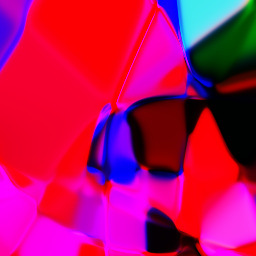

In [48]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate one image</font></b>
z1 = sampler.generate_z()
sampler.to_image(sampler.generate(z1))
#sampler.save_png(sampler.generate(z1), '/content/result.png')

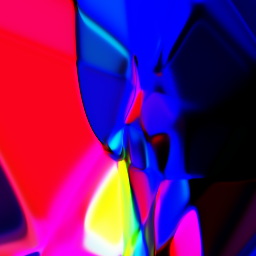

In [49]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate another image</font></b>
gen_type = "new" #@param ["new", "zoom in", "zoom out", "zoom in2out"]

if gen_type == "new": z2 = sampler.generate_z()
elif gen_type == "zoom in": z2 = z1 * 3.1
elif gen_type == "zoom out": z2 = z1 * 0.01
elif gen_type == "zoom in2out": z2 = z1 * (-1)

sampler.to_image(sampler.generate(z2))
#sampler.save_png(sampler.generate(z2), '/content/result.png')

In [52]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate video with transition between two images</font></b>

#@markdown *The number of intermediate frames between the first and second picture:*
n_frame = 100 #@param {type:"integer"}

!rm -rf /content/frames
!mkdir /content/frames

delta_z = (z2-z1) / (n_frame+1)
for i in tqdm(range(n_frame+2)):
  z = z1 + delta_z*float(i)
  sampler.save_png(sampler.generate(z), f'/content/frames/{str(i).zfill(7)}.png')

!ffmpeg -y -r 24 -i /content/frames/%07d.png -c:v libx264 -vf fps=24 -pix_fmt yuv420p /content/result.mp4
clear_output()

#@markdown *If the checkbox is not checked, then the video will just appear below:*
download_video = False #@param {type:"boolean"}
if download_video: files.download('/content/result.mp4')
else: display(mpy.ipython_display('/content/result.mp4', autoplay=1, loop=1))

In [54]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate video with transition between two images with additional continuation</font></b>

#@markdown *The number of intermediate frames between the first and second picture:*
n_frame =  50 #@param {type:"integer"}
#@markdown *The multiplicity of increasing the duration of the video:*
multiplicity = 3 #@param {type:"integer"}

!rm -rf /content/frames
!mkdir /content/frames

delta_z = (z2-z1) / (n_frame+1)
for i in tqdm(range(n_frame*multiplicity)):
  z = z1 + delta_z*float(i)
  sampler.save_png(sampler.generate(z), f'/content/frames/{str(i).zfill(7)}.png')

!ffmpeg -y -r 24 -i /content/frames/%07d.png -c:v libx264 -vf fps=24 -pix_fmt yuv420p /content/result.mp4
clear_output()

#@markdown *If the checkbox is not checked, then the video will just appear below:*
download_video = False #@param {type:"boolean"}
if download_video: files.download('/content/result.mp4')
else: display(mpy.ipython_display('/content/result.mp4', autoplay=1, loop=1))

In [51]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate video with transition between random images</font></b>

#@markdown *The number of random abstractions:*
n_absract = 10 #@param {type:"integer"}
#@markdown *The number of intermediate frames between the first and second picture:*
n_frame = 50 #@param {type:"integer"}

!rm -rf /content/frames
!mkdir /content/frames

if n_absract >= 2:
  first = sampler.generate_z()
  vectors = [first]
  for i in range(n_absract-1):
    vectors.append(sampler.generate_z())
  vectors.append(first)

  all_vec = []
  for i in range(len(vectors)-1):
    delta_z = (vectors[i+1]-vectors[i]) / (n_frame+1)
    for k in range(n_frame+1):
      all_vec.append(vectors[i]+delta_z*float(k))

  for i in tqdm(range(len(all_vec))):
    sampler.save_png(sampler.generate(all_vec[i]), f'/content/frames/{str(i).zfill(7)}.png')

  !ffmpeg -y -r 24 -i /content/frames/%07d.png -c:v libx264 -vf fps=24 -pix_fmt yuv420p /content/result.mp4
  clear_output()

  #@markdown *If the checkbox is not checked, then the video will just appear below:*
  download_video = False #@param {type:"boolean"}
  if download_video: files.download('/content/result.mp4')
  else: display(mpy.ipython_display('/content/result.mp4', autoplay=1, loop=1))
else: print('Please enter n_abstract more than 2')